<a href="https://colab.research.google.com/github/dtabuena/Images/blob/main/Analyzing_Confocal_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install python-bioformats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
import numpy as np
import javabridge
import bioformats
import skimage
from skimage import filters
from matplotlib import pyplot as plt
import matplotlib
import os
import scipy
javabridge.start_vm(class_path=bioformats.JARS)

In [29]:

def get_drobox_folder(link, new_filename):
    'Download a folder from dropbox and unzip'
    zipped_file_path = "/content/"+new_filename + ".zip"
    unzipped_file_path = "/content/"+new_filename
    if not( os.path.exists(zipped_file_path)):
        !wget -O $zipped_file_path $link    # download with new name
    !echo A | unzip $zipped_file_path -d $unzipped_file_path 
    return new_filename

def get_sub_files(rootdir):
    'Recursively search subfolders and return a list of all files'
    file_list =[]
    for rootdir, dirs, files in os.walk(rootdir): 
            file_list.extend([os.path.join(rootdir,f) for f in files])
    return file_list

folder = get_drobox_folder('https://www.dropbox.com/sh/rv7944fsk9p1mvk/AAC0E8ZTPkr-pfgK8zdC730Sa?dl=0', 'images')
file_list = get_sub_files(folder)

Archive:  /content/images.zip
mapname:  conversion of  failed
replace /content/images/MDGA2_08-24-22_DG_40X_2XZoom_1.oir? [y]es, [n]o, [A]ll, [N]one, [r]ename:  extracting: /content/images/MDGA2_08-24-22_DG_40X_2XZoom_1.oir  
 extracting: /content/images/MDGA2_08-25-22_DG_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-04-22_DG_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-04-22_CA3_40X_2XZoom_1.oir  
 extracting: /content/images/RNF182_08-15-22_CA3_40X_2XZoom_1.oir  
 extracting: /content/images/MDGA2_08-22-22_S001_DG_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-10-22__S001_DG_40X_2XZoom_2.oir  
 extracting: /content/images/RNF182_08-17-22_S001_DG_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-10-22__S001_CA3_40X_2XZoom_2.oir  
 extracting: /content/images/RNF182_08-12-22_S001_CA3_40X_2XZoom_1.oir  
 extracting: /content/images/Other/DifferentExposure_RNF182_08-15-22_DG_40X_2XZoom_1.oir  
 extracting: /content/images/Other/BrighterSettings_Nel

In [30]:
file_list

['images/RNF182_08-12-22_S001_CA3_40X_2XZoom_1.oir',
 'images/Nell2_08-10-22__S001_DG_40X_2XZoom_2.oir',
 'images/MDGA2_08-24-22_DG_40X_2XZoom_1.oir',
 'images/Nell2_08-10-22__S001_CA3_40X_2XZoom_2.oir',
 'images/Nell2_08-04-22_CA3_40X_2XZoom_1.oir',
 'images/RNF182_08-15-22_CA3_40X_2XZoom_1.oir',
 'images/Nell2_08-04-22_DG_40X_2XZoom_1.oir',
 'images/MDGA2_08-22-22_S001_DG_40X_2XZoom_1.oir',
 'images/RNF182_08-17-22_S001_DG_40X_2XZoom_1.oir',
 'images/MDGA2_08-25-22_DG_40X_2XZoom_1.oir',
 'images/Other/DifferentExposure_RNF182_08-15-22_DG_40X_2XZoom_1.oir',
 'images/Other/BrighterSettings_Nell2_08-10-22_S001_DG_40X_2XZoom_1.oir',
 'images/Other/BrighterSettings_Nell2_08-10-22_S001_CA3_40X_2XZoom_1.oir']

In [31]:
my_reader = bioformats.get_image_reader('my_image', file_list[7])

c_dim = my_reader.rdr.getSizeC()
z_dim = my_reader.rdr.getSizeZ()
x_dim = my_reader.rdr.getSizeX()
y_dim = my_reader.rdr.getSizeY()
print(x_dim,y_dim,c_dim,z_dim)

image = np.empty([x_dim,y_dim,c_dim,z_dim])
for zi in range(z_dim):
    img_zi = my_reader.read(c=None, z=zi,rescale=True)
    image[:,:,:,zi] = img_zi


image_zproj = np.max(image,axis=3)
# image = np.expand_dims(image_zproj, axis=-1)
print(image.shape)
for ci in range(image.shape[2]):
    cim = image[:,:,ci,:]
    flat = cim.flatten()
    max= np.percentile(flat,100)
    assert max>0 , print(flat)
    cim = cim/max
    image[:,:,ci,:] = cim

800 800 3 13
(800, 800, 3, 13)


In [32]:
def new_colormap(start,stop,n=256):
    start = np.array(start)
    stop = np.array(stop)
    delta_ni = np.expand_dims((stop-start)/n,-1)
    ni = np.expand_dims(np.arange(n),-1)
    cmap_np = start + np.multiply(delta_ni.T,ni)
    return matplotlib.colors.ListedColormap(cmap_np)


green_map = new_colormap([0,0,0,1],[0,1,0,1])
red_map = new_colormap([0,0,0,1],[1,0,0,1])
white_map = new_colormap([0,0,0,1],[1,1,1,1])
blue_map = new_colormap([0,0,0,1],[0,0,1,1])

In [33]:
neun_im = image[:,:,2,:]
ratio = np.array([4,3])
n = neun_im.shape[2]
h = ratio[0]
w = np.ceil(n/h)
hw = np.array([h,w])
print(ratio-hw)

[ 0. -1.]


[[248 184   1]
 [225 212   1]
 [223 214   1]
 [242 189   1]
 [ 36 189   1]
 [238 194   1]
 [234 199   1]
 [ 38 191   2]
 [ 32 185   1]
 [ 15 170   1]
 [ 20 174   1]
 [ 18 172   1]
 [ 18 173   1]
 [ 19 173   1]
 [ 19 174   1]
 [156 217   1]
 [156 218   1]
 [157 218   1]
 [158 217   1]
 [158 218   1]
 [159 217   1]
 [160 217   1]
 [160 218   1]
 [157 217   1]
 [162 218   1]
 [161 218   1]
 [159 218   1]
 [168 219   1]
 [167 219   1]
 [172 220   1]
 [ 79 223   1]
 [ 78 221   1]
 [117 145   1]
 [ 62 131   1]
 [ 64 130   1]
 [182 142   1]
 [180 141   1]
 [ 75 208   2]
 [ 31 216   1]
 [ 75 131   1]
 [ 77 132   1]
 [ 95 163   1]
 [173 140   1]
 [ 93 162   1]
 [ 52 186   1]
 [ 52 185   1]
 [ 52 187   1]
 [ 52 188   1]
 [191 185   1]
 [ 52 184   1]
 [ 52 183   1]
 [191 184   1]
 [ 83 138   1]
 [ 82 137   1]
 [ 84 139   1]
 [171 141   1]
 [169 144   1]
 [158 168   1]
 [158 169   1]
 [ 86 143   1]
 [ 85 141   1]
 [168 146   1]
 [ 53 190   1]
 [167 151   1]
 [167 148   1]
 [ 20 222   1]
 [167 149 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: No contour levels were found within the data range.


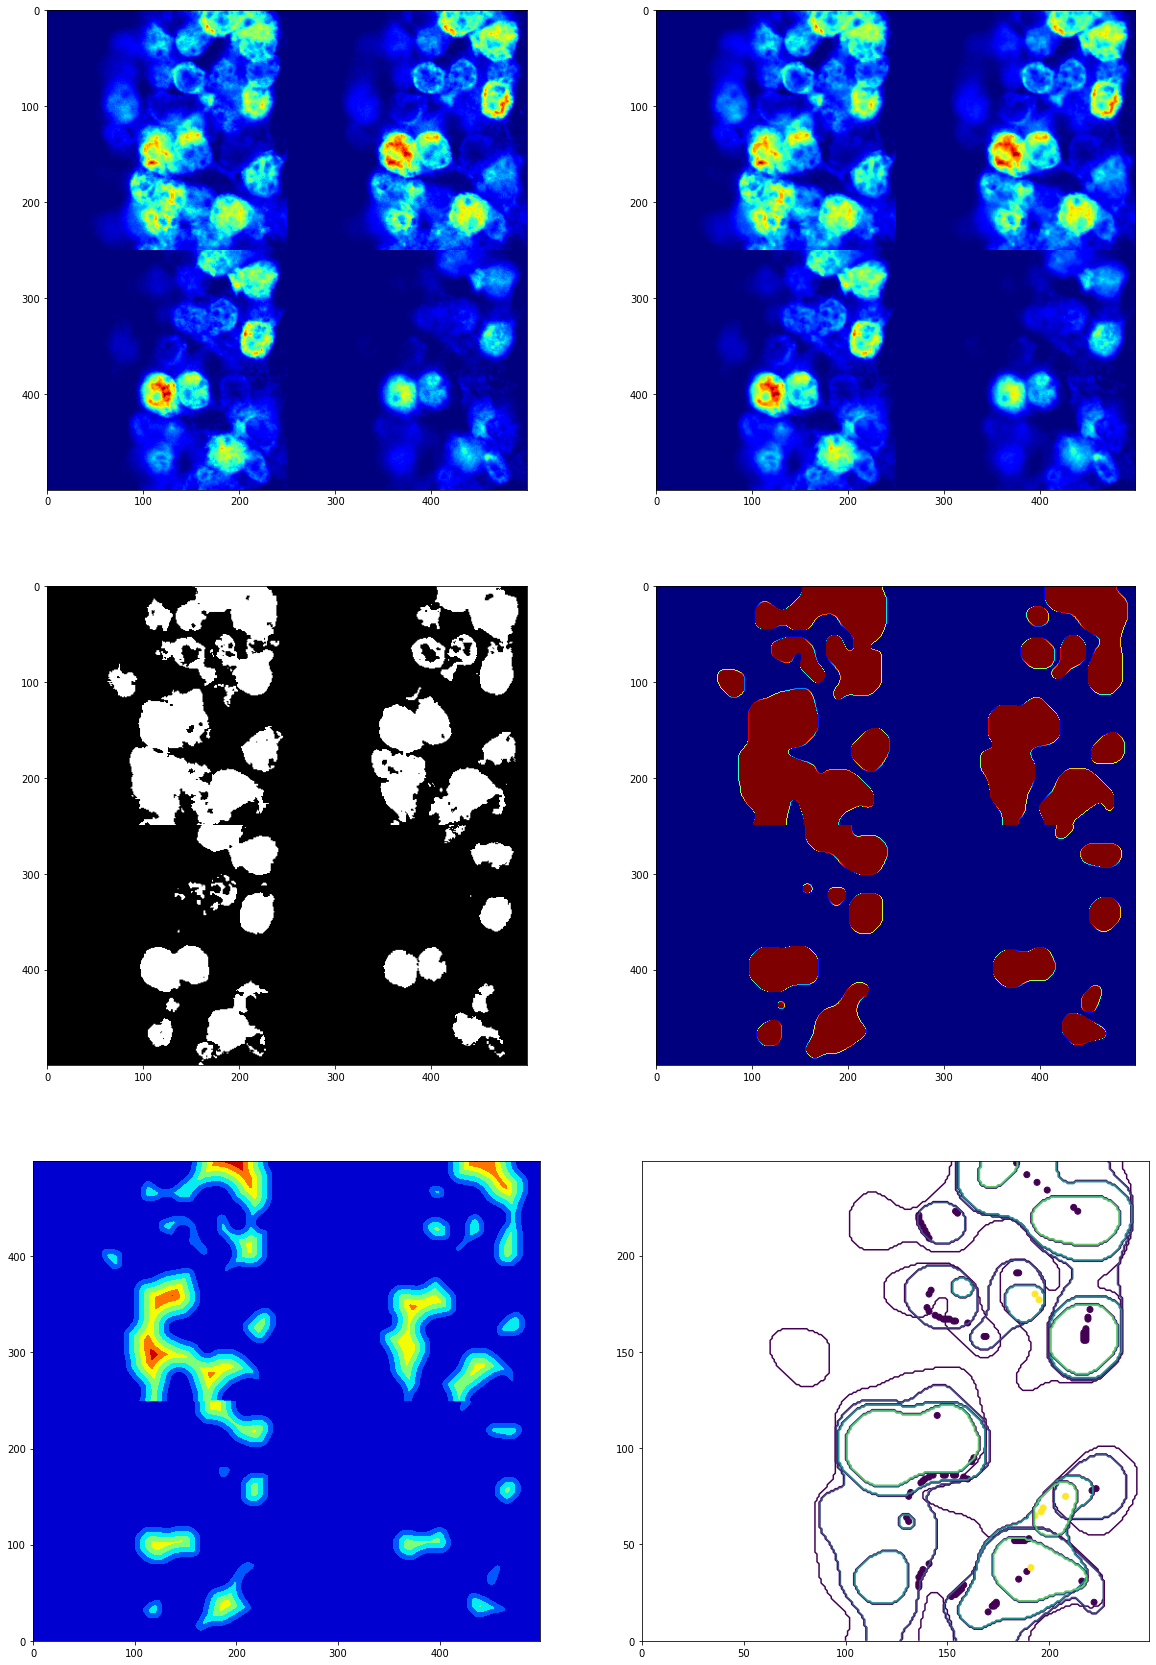

In [78]:
####################### Process NEUN
neun_im = image[300:550,300:550,2,9:14]
neun_im = neun_im/np.max(neun_im.flatten())
neun_im_og = neun_im

# g_sigma_1 = .2
# g_sigma_2 = 5
# neun_im = skimage.filters.gaussian(neun_im, sigma = g_sigma_1)   #### blur
# neun_im_bk = skimage.filters.gaussian(neun_im, sigma = g_sigma_2)  ### get background from big blur
# neun_im_bs = neun_im - neun_im_bk

neun_im = skimage.filters.median(neun_im, selem=skimage.morphology.ball(1)) 

thresh = skimage.filters.threshold_otsu(neun_im.flatten())
neun_im_bin = neun_im>thresh


neun_im_bin_smo = neun_im_bin
foot = skimage.morphology.disk(4)
# print(foot)
foot = np.stack([np.zeros_like(foot),foot,np.zeros_like(foot)],axis=-1)
iter = 10
x = neun_im_bin_smo*1
for i in range(iter):
    neun_im_bin_smo = skimage.filters.rank.mean(neun_im_bin_smo, selem=foot) > 256*0.45
    x = x + neun_im_bin_smo*1


# from skimage.segmentation import watershed


distance = scipy.ndimage.distance_transform_edt(neun_im_bin_smo, sampling=[1,1,25], return_distances=True)
peak_foot = np.ones((3, 3, 3))


sp=6
sp_size = 10
r = 3
fig_mont, ax_mont= plt.subplots(r,int(np.ceil(sp/r)),figsize=(sp_size*int(np.ceil(sp/r)),sp_size*r))
ax_mont = ax_mont.flatten()
ax_mont[0].imshow(skimage.util.montage(np.transpose(neun_im_og,(2,0,1))),cmap='jet')
ax_mont[1].imshow(skimage.util.montage(np.transpose(neun_im,(2,0,1))),cmap='jet')
ax_mont[2].imshow(skimage.util.montage(np.transpose(neun_im_bin,(2,0,1))),cmap='gray')
ax_mont[3].imshow(skimage.util.montage(np.transpose(neun_im_bin_smo,(2,0,1))),cmap='jet')
ax_mont[4].contourf(np.flip(skimage.util.montage(np.transpose(distance,(2,0,1))),0),cmap='jet')
for zi in range(neun_im_bin_smo.shape[2]):
    ax_mont[5].contour(np.flip(neun_im_bin_smo[:,:,zi]*(zi+1),0),levels=np.arange(5))
    # print(neun_im_bin_smo[:,:,zi]*(zi+1))


coords = skimage.feature.peak_local_max(np.flip(distance,0), footprint=peak_foot, labels=neun_im_bin_smo,exclude_border=False)
print(coords)
ax_mont[5].scatter(coords[:,1],coords[:,0],c=coords[:,2])

# plt.plot(neun_im_bin_smo[150,:,1])

In [35]:

# distance = scipy.ndimage.distance_transform_edt(neun_im_sbin_e, sampling=sampling, return_distances=True)
# ax_mont[6].imshow(skimage.util.montage(np.transpose(distance,(2,0,1))),cmap='jet')



# from skimage.segmentation import watershed
# from skimage.feature import peak_local_max
# from scipy import ndimage as ndi

# distance = scipy.ndimage.distance_transform_edt(neun_im_sbin, sampling=sampling, return_distances=True)

# f = 30
# coords = peak_local_max(distance, footprint=np.ones((f, f, f)), labels=neun_im_sbin)
# mask = np.zeros(distance.shape, dtype=bool)
# mask[tuple(coords.T)] = True
# markers, _ = ndi.label(mask)
# labels = watershed(-distance, markers, mask=neun_im_sbin)

# ax_mont[7].imshow(skimage.util.montage(np.transpose(labels,(2,0,1))), cmap=plt.cm.nipy_spectral)

